# KR - Wav2vec2 Finetuning

- Dataset : Ksponspeech (from AI hub)
- Model : wav2vec2-XLSR-53 (53 language, 56k hours pretrained)

https://huggingface.co/facebook/wav2vec2-large-xlsr-53

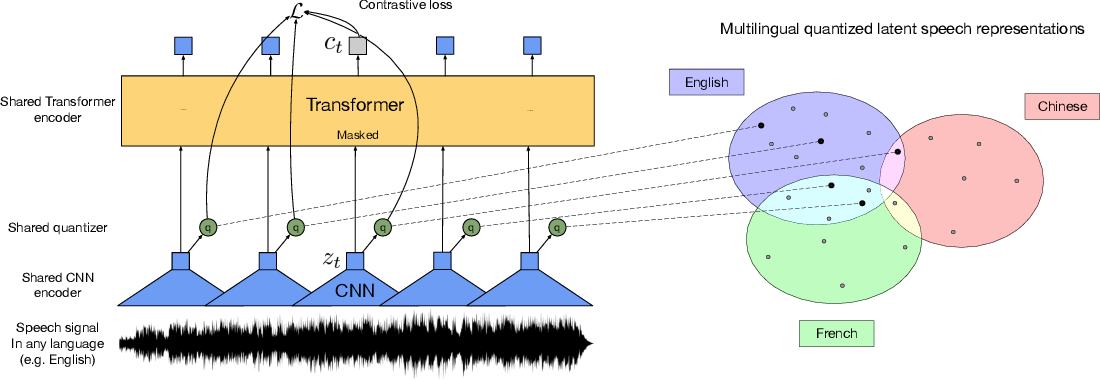

In [24]:
from IPython.display import Image

Image('./figs/xlsr_wav2vec2.png')

# Vocabs

- Generate vocabs
- character level vocabs
- from aihub, kospeech


In [1]:
import pandas as pd

vocabs_csv=pd.read_csv("./util_data/aihub_character_vocabs.csv")
vocabs_csv


,id,char,freq
0,0,<pad>,0
1,1,<sos>,0
2,2,<eos>,0
3,3,,5774244
4,4,.,640923
...,...,...,...
1995,1995,솝,2
1996,1996,솎,2
1997,1997,샅,2
1998,1998,삻,2


In [2]:
#vocabs to json
import json
vocabs_csv = vocabs_csv[['char','id']]
# 'char', 'id' to json. key is char, id is value. example {'<pad>':1,}
vocabs_json = vocabs_csv.to_json(orient='values',force_ascii=False)
vocabs_json = json.loads(vocabs_json)
vocabs_json = dict(vocabs_json)

with open('./util_data/aihub_character_vocabs.json', 'w', encoding='utf-8') as make_file:
    json.dump(vocabs_json, make_file, indent="\t")
print(vocabs_json)

{'<pad>': 0, '<sos>': 1, '<eos>': 2, ' ': 3, '.': 4, '그': 5, '이': 6, '는': 7, '아': 8, '가': 9, '고': 10, '어': 11, '거': 12, '지': 13, '데': 14, '?': 15, '나': 16, '하': 17, '다': 18, '서': 19, '에': 20, '도': 21, '게': 22, '니': 23, '기': 24, '은': 25, '면': 26, '야': 27, '있': 28, '한': 29, '을': 30, '까': 31, '해': 32, '리': 33, '라': 34, '래': 35, '사': 36, '근': 37, '들': 38, '안': 39, '로': 40, '일': 41, '뭐': 42, '내': 43, '보': 44, '제': 45, '같': 46, '자': 47, '만': 48, '시': 49, '런': 50, '너': 51, '대': 52, '때': 53, '되': 54, '으': 55, '진': 56, '를': 57, '잖': 58, '오': 59, '러': 60, '인': 61, '막': 62, '무': 63, '었': 64, '구': 65, '했': 66, '수': 67, '간': 68, '애': 69, '우': 70, '요': 71, '마': 72, '생': 73, '렇': 74, '냥': 75, '짜': 76, '주': 77, '없': 78, '말': 79, '학': 80, '스': 81, '더': 82, '많': 83, '원': 84, '음': 85, '정': 86, '겠': 87, '여': 88, '먹': 89, '금': 90, '든': 91, '부': 92, '할': 93, '전': 94, '번': 95, '좋': 96, '랑': 97, '네': 98, '람': 99, '약': 100, '건': 101, '각': 102, '좀': 103, '알': 104, '잘': 105, '걸': 106, '모': 107, '것': 108, '상': 10

# Tokenizer, Feature extractor, processor

- Tokenizer : 전사데이터(label)을 vocab에 따라 전처리 해주는 모듈
- Feature extractor : 모델에 들어갈 음성 신호를 Convolution 해주는 모듈
- processor : Tokenizer,Feature extractor를 묶어서 사용

In [3]:
# load pretrained model
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor


tokenizer = Wav2Vec2CTCTokenizer("./util_data/aihub_character_vocabs.json",
                                 unk_token="<unk>",
                                 pad_token="<pad>",
                                 word_delimiter_token=" ")

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,
                                     sampling_rate=16000,
                                     padding_value=0.0,
                                     do_normalize=True,
                                     return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
#model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53")

/hdd/anaconda3/envs/asr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer("안녕 하세요",return_attention_mask=True,return_tensors="pt")

{'input_ids': tensor([[ 39, 962,   3,  17, 165,  71]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [24]:
tokenizer("안녕 하세요 <pad>",return_attention_mask=True,return_tensors="pt")

{'input_ids': tensor([[ 39, 962,   3,  17, 165,  71,   0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

# Dataset Preprocess


- remove special characters 
- audio data to transformer dataset

In [6]:
from datasets import load_dataset, load_metric, Audio

In [7]:
# dataset 확인
from glob import glob
glob("./data/wav/*.wav")[:10]

['./data/wav/EA_0371-781-04-01-KGH-M-07-A.wav',
 './data/wav/EA_0381-533-04-01-CYH-F-08-A.wav',
 './data/wav/EA_0374-674-04-01-YMD-F-08-A.wav',
 './data/wav/EA_0381-863-04-01-CYH-F-08-A.wav',
 './data/wav/EA_0379-972-04-01-JYT-M-07-C.wav',
 './data/wav/EA_0381-739-04-01-CYH-F-08-A.wav',
 './data/wav/EA_0374-878-04-01-YMD-F-08-A.wav',
 './data/wav/EA_0381-879-04-01-CYH-F-08-A.wav',
 './data/wav/EA_0381-787-04-01-CYH-F-08-A.wav',
 './data/wav/EA_0374-867-04-01-YMD-F-08-A.wav']

In [8]:
# label 확인
pd.read_csv('./data/label/sample_label.csv')

,filename,transcript
0,EA_0374-928-04-01-YMD-F-08-A.wav,내 기준으로 날씨 알려 주도록 해.
1,EA_0381-887-04-01-CYH-F-08-A.wav,메밀 소바 세트 주문하는데 음료만 사이다로 변경해 줘.
2,EA_0371-571-04-01-KGH-M-07-A.wav,교수님한테 온 카톡에 답장할래.
3,EA_0371-752-04-01-KGH-M-07-A.wav,오늘 청평에 캠핑 가는데 청평 밤 기온 몇 도까지 내려가는지 알려 줘.
4,EA_0374-529-04-01-YMD-F-08-A.wav,오늘 고양 오리온 경기 시간이 언제지?
...,...,...
1415,EA_0371-972-04-01-KGH-M-07-A.wav,에어프라이어 레시피 몇 가지 알려 줘.
1416,EA_0379-972-04-01-JYT-M-07-C.wav,에어프라이어 레시피 몇 가지 알려 줘.
1417,EA_0374-920-04-01-YMD-F-08-A.wav,오버워치 리그 일정 확인하게 사이트 열어 줘.
1418,EA_0371-686-04-01-KGH-M-07-A.wav,주변 음식점 중 횟집만 골라 줘.


In [19]:
import torch
import torchaudio
from functools import partial


audio_dataset=load_dataset(
    "csv",
    data_files={
        "train": "./data/label/sample_label.csv",
    },
)
# [filename,transcript]로 이뤄진 데이터


def speech_to_batch(hub_dataset,processor):
    # 데이터를 읽어서 배치로 만들기.
    
    audio_path  = "./data/wav/"+hub_dataset["filename"]
    speech_data, sampling_rate = torchaudio.load(audio_path)
    transcript = hub_dataset["transcript"]
    #resample
    if sampling_rate != 16000:
        #resample using torchaudio
        resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
        speech_data=resampler(speech_data)[0]
    
    hub_dataset["input_values"] = processor(audio=speech_data, sampling_rate=16000,return_tensors="pt").input_values[0]

    hub_dataset["labels"] = processor(text=transcript).input_ids
            
    return hub_dataset

audio_dataset = audio_dataset['train'].map(partial(speech_to_batch,processor=processor),remove_columns=audio_dataset['train'].column_names, num_proc=8)

    


Found cached dataset csv (/home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
100%|██████████| 1/1 [00:00<00:00, 1791.67it/s]
Loading cached processed dataset at /home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-956e32e9fafb8293_*_of_00008.arrow


In [20]:
# 들어보기 

import IPython.display as ipd
import numpy as np
import random

print(audio_dataset[0]['labels'])
print("번역한 전사본 : ",tokenizer.batch_decode(audio_dataset[0]['labels']))

ipd.Audio(data=np.asarray(audio_dataset[0]['input_values']), autoplay=True, rate=16000)

[43, 3, 24, 247, 55, 40, 3, 122, 386, 3, 104, 110, 3, 77, 21, 479, 3, 32, 4]
번역한 전사본 :  ['내', '', '기', '준', '으', '로', '', '날', '씨', '', '알', '려', '', '주', '도', '록', '', '해', '.']


In [11]:
audio_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 1420
})

In [25]:
# train, valid split

audio_dataset = audio_dataset.train_test_split(test_size=0.2,seed=42)


Loading cached split indices for dataset at /home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-62d1378fd74c9de3.arrow and /home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-8cfd2b4ba2a300fa.arrow


In [26]:

# 데이터 패딩 시켜주는 함수
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union


import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features=input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
                
        labels_batch = self.processor.pad(
            labels=label_features,
            padding=self.padding,
            max_length=self.max_length_labels,
            pad_to_multiple_of=self.pad_to_multiple_of_labels,
            return_tensors="pt",
        )  
        # replace padding with [pad] to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


In [28]:
#정확도 계산

cer_metrics = load_metric("cer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    cer = cer_metrics.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}



# Fine-tuning

In [30]:
# model 제작
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

# CNN 파트는 학습 X
model.freeze_feature_extractor()



Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'project_q.weight', 'project_hid.weight', 'project_q.bias', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir='./results/',
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=1000,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  push_to_hub=False,
)

In [32]:
audio_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 284
    })
})

In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=audio_dataset["train"],
    eval_dataset=audio_dataset["test"],
    tokenizer=processor.feature_extractor
)




In [34]:
# train
trainer.train()

/hdd/anaconda3/envs/asr/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
100,58.224400,31.355165,1.000000
200,17.829700,6.319502,1.000000
300,4.829000,4.367513,0.952651
400,4.206700,4.064740,0.918113
500,3.919300,3.904196,0.808173
600,3.508400,3.137603,0.769742
700,2.026400,1.324723,0.329658
800,0.671000,0.682280,0.215015
900,0.280500,0.479320,0.189233
1000,0.175000,0.402617,0.150478


TrainOutput(global_step=35000, training_loss=0.2803832694374158, metrics={'train_runtime': 39261.3266, 'train_samples_per_second': 28.934, 'train_steps_per_second': 0.891, 'total_flos': 1.5750950382818427e+20, 'train_loss': 0.2803832694374158, 'epoch': 985.92})

# Inference

In [35]:
trainer.evaluate()

{'eval_loss': 0.26017865538597107,
 'eval_cer': 0.11723690611318308,
 'eval_runtime': 6.2022,
 'eval_samples_per_second': 45.79,
 'eval_steps_per_second': 5.804,
 'epoch': 985.92}

In [36]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor


#processor = Wav2Vec2Processor.from_pretrained("./results/checkpoint-9400/")

tokenizer = Wav2Vec2CTCTokenizer("./util_data/aihub_character_vocabs.json",
                                 unk_token="<unk>",
                                 pad_token="<pad>",
                                 word_delimiter_token=" ")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("./results/checkpoint-35000/")
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

model = Wav2Vec2ForCTC.from_pretrained("./results/checkpoint-35000/").to("cuda")

In [37]:
import torch
import torchaudio
from functools import partial


audio_dataset=load_dataset(
    "csv",
    data_files={
        "train": "./data/label/sample_label.csv",
    },
)
# [filename,transcript]로 이뤄진 데이터


def speech_to_batch(hub_dataset,processor):
    # 데이터를 읽어서 배치로 만들기.
    
    audio_path  = "./data/wav/"+hub_dataset["filename"]
    speech_data, sampling_rate = torchaudio.load(audio_path)
    transcript = hub_dataset["transcript"]
    #resample
    if sampling_rate != 16000:
        #resample using torchaudio
        resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
        speech_data=resampler(speech_data)[0]
    
    hub_dataset["input_values"] = processor(audio=speech_data, sampling_rate=16000,return_tensors="pt").input_values[0]

    hub_dataset["labels"] = processor(text=transcript).input_ids
            
    return hub_dataset

audio_dataset = audio_dataset['train'].map(partial(speech_to_batch,processor=processor),remove_columns=audio_dataset['train'].column_names, num_proc=1)
# train, valid split
audio_dataset = audio_dataset.train_test_split(test_size=0.2,seed=42)

    


Found cached dataset csv (/home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
100%|██████████| 1/1 [00:00<00:00, 1780.26it/s]
Loading cached processed dataset at /home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-28b83511d2c923a7.arrow
Loading cached split indices for dataset at /home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-faec46109c024467.arrow and /home/jongbub/.cache/huggingface/datasets/csv/default-dfc4fc801942e21b/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-4c8e3491e3fc4220.arrow


In [39]:

def map_to_pred(batch):
    inputs = processor(batch["input_values"], return_tensors="pt", padding="longest", sampling_rate = 16000)
    input_values = inputs.input_values.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch


results=audio_dataset["test"].map(map_to_pred, batched=True, batch_size=8, remove_columns=audio_dataset["test"].column_names, num_proc=1)

In [40]:
cer_metrics.compute(predictions=results["transcription"],references=processor.batch_decode(audio_dataset["test"]["labels"]))

0.119148244473342

In [41]:
for a in zip(results['transcription'],processor.batch_decode(audio_dataset["test"]["labels"])):
    print(a)

('내뉴에 남  있어?어?', '메뉴에 라면 있어?')
('내일 많이 추운지 확인 한번 확인해 봐.라.', '내일 많이 추운지 확인 한번 해 봐.')
('육즙을 보관할 수 있는 고기 굽는 노하우 알아?아?', '육즙을 보관할 수 있는 고기 굽는 노하우 알아?')
('연어 음식 레시피 동영상 고화질 볼래.', '연어 음식 레시피 동영상 고화질로 볼래.')
('에어컨 삼 단계로 설정해 줘.줘.', '에어컨 삼 단계로 설정해 줘.')
('몸이 너무 안 좋은데 오늘 많이 추울까?까?몸', '몸이 너무 안 좋은데 오늘 많이 추울까?')
('이리랑 경기 지역기랑 시가 다은지 알려 줘.줘.줘.줘.', '여기랑 경기 지역이랑 날씨가 다른지 알려 줘.')
('오늘 짜증 나는데 시끄러운 록음악 틀어 줘.줘.', '오늘 짜증 나는데 시끄러운 록 음악 틀어 줘.')
('검색어 검색 한번 해 줄래?래?검', '검색어 검색 한번 해 줄래?')
('써브웨이 샌드위치 재료 확인해 줘.줘.', '써브웨이 샌드위치 재료 확인해 줘.')
('계속 눈물 나는데 비는 언제 안 와?와?계', '계속 눈물 나는데 비는 언제 안 와?')
('내가 등록한 식당 가까운 곳이 어디야?야?내', '내가 등록한 식당 가까운 곳이 어디야?')
('여기 맛있는 마카롱 집이 어디인지 검색해 줘.줘.', '여기 맛있는 마카롱 집이 어디인지 검색해 줘.')
('다음주 날씨 강수량 위주로 요약해 줘.줘.', '다음주 날씨 강수량 위주로 요약해 줘.')
('오늘 청평에 캠핑 가는데 청평 밤 기온 몇 도까지 내려가는지 알려 줘.', '오늘 청평에 캠핑 가는데 청평 밤 기온 몇 도까지 내려가는지 알려 줘.')
('도드람 리그 현재 순위 보여 줘.줘.', '도드람 리그 현재 순위 보여 줘.')
('에프엠 구십일 점 구에서 뭐 하는지 검색해 줘.', '에프엠 구십일 점 구에서 뭐 하는지 검색해 줘.')
('오늘 해외 클라이언어트 화상 회의 몇 시야?야?', '오늘 해외 클라이언트 화상 회의 몇 시야?')
('삼성전자 일 년 전 주